# Analyse the CrowdFlower results (gender identification)

In [9]:
%pylab inline
import urllib2
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
import sys
import json
def load_simple_json(filename):
    with open(filename, 'r') as f:
        return json.load(f,encoding="utf-8")

#===== load df with profesion-image correspondences
df_images=pd.read_csv("profession_images_all.csv",sep='\t', encoding='utf-8',index_col=0)
df_with_image=df_images[df_images.image_link!="-"]
df_with_image_without_svg=df_with_image[~df_with_image.image_link.str.contains(".svg")]
df=df_with_image_without_svg[~df_with_image_without_svg.image_link.str.contains(".ogg|.ogv")]
print "Images without .svg and video:",len(df)
print "We have approx",len(df)/float(len(pd.unique(df.profession))),\
"pictures per profession with image. "+"We have",len(pd.unique(df.profession)),"professions with image."
df_unique=df[~df.duplicated('image_link')]
print "Among them ",len(df_unique), "unique images."

#===== load aggregated results:
result_old= pd.read_csv("a725997.csv", delimiter=",", header=0)#results from previous project
result= pd.read_csv("a861276_best.csv", delimiter=",", header=0)#new results

#==== load dictionary with old url to image names correspondences
old_link_name_new=load_simple_json("de/old_link_name_new.json")

Populating the interactive namespace from numpy and matplotlib
Images without .svg and video: 907
We have approx 2.62898550725 pictures per profession with image. We have 345 professions with image.
Among them  889 unique images.


In [11]:
#combine images from old results and new results
result_old.loc[:,'no_of_persons']=result_old['no_of_persons'].str.lower().str.replace(r',|\*|\'',"").str.replace(" ","_")
result_old.loc[:,"person_plural"]=result_old["person_plural"].str.lower().str.replace(r',|\)|\(',"").str.replace(" ","_").\
str.replace("i'm_not_sure","gender_is_not_recognizable")
result_old.loc[:,"person_singular_dom"]=result_old["person_singular_dom"].str.lower().str.replace(" ","_").\
str.replace("i'm_not_sure","gender_is_not_recognizable")
result_old.loc[:,"person_singular_nondom"]=result_old["person_singular_nondom"].str.lower().str.replace(" ","_").\
str.replace("i'm_not_sure","gender_is_not_recognizable")
#result_old[(~result_old.person_plural.isnull()) ]

result.loc[:,"real_url"]=result.apply(lambda x: x["image_url"], axis = 1)
old_link_new_link={}
for link in old_link_name_new:
    j=old_link_name_new[link]
    old_link_new_link[link]=df[df.image_name==urllib2.unquote(j.replace("_"," ").encode('utf-8')).decode('utf-8')].image_link.values[0]
old_results_for_or_data=result_old[result_old.image_url.isin(old_link_name_new.keys())]#125
old_results_for_or_data.loc[:,"real_url"]=old_results_for_or_data.apply(lambda x: old_link_new_link[x["image_url"]], axis = 1)
data=pd.concat([result, old_results_for_or_data], ignore_index=True) 
#data #1049 #896-unique
#data[data._unit_state=="finalized"]#893
#data[~data.duplicated('image_url') &(data._unit_state=="finalized") ]#889
#data[(data.person_plural=="i'm_not_sure")|(data.person_singular_dom=="i'm_not_sure")|(data.person_singular_nondom=="i'm_not_sure")]

no_of_persons
image_is_not_shown                                           2
no_person                                                  311
one_person                                                 284
several_persons_but_one_persons_depiction_is_dominant       52
several_persons_no_single_persons_depiction_is_dominant    244
dtype: int64


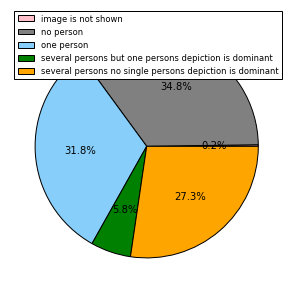

In [12]:
#exclude test questions
result_all= data[data._unit_state == "finalized"]
result_all_grouped =  result_all.groupby("no_of_persons").size()
print result_all_grouped
colors = ['pink',  'grey', 'lightskyblue', 'green', 'orange', 'blue']
plt.figure(1, figsize=(5,5))
plt.pie(result_all_grouped.values, colors=colors, autopct='%1.1f%%') #, pctdistance=1.1, labeldistance=1.2
plt.legend(result_all_grouped.index.str.replace("_"," "),loc="best",fontsize='small')
plt.show()
#plt.savefig("results/answer-types.png", bbox_inches='tight')

Distribution of images in profession articles on German Wikipedia is the same as for profesion articles over all other Wikipedia editions (See Claudia Wagner's research).
Distribution of images from Claudia's project:

<img src="../../../ProfImageWikipedia/src/WikipediaImageBias/results/answer-types.png" style="float: left;" alt="Previous project. All language editions (90 professions)" width="300"/>

There are  580  images with at least one person.
Among them are:

female                         71
gender_is_not_recognizable     18
male                          247
dtype: int64


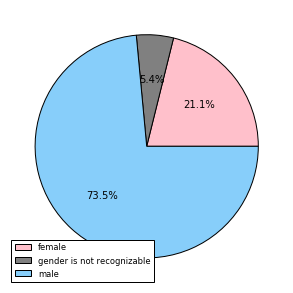

In [13]:
# remove non-person pics
person_docs = result_all[~(result_all.no_of_persons.str.contains("no_person|image_is_not_shown"))] #580
print "There are ",len(person_docs)," images with at least one person."
print "Among them are:"
singular_person_docs = person_docs.groupby("person_singular_nondom").size()
#print singular_person_docs
mult_person_docs_dom = person_docs.groupby("person_singular_dom").size()
#print mult_person_docs_dom
all_singular_persons = mult_person_docs_dom+singular_person_docs
all_singular_persons.keys().name=""#"all_singular_persons"
print all_singular_persons
plt.figure(1, figsize=(5,5))
plt.pie(all_singular_persons.values, colors=colors, autopct='%1.1f%%') #, pctdistance=1.1, labeldistance=1.2
plt.legend(all_singular_persons.index.str.replace("_"," "),loc="best",fontsize='small')
plt.show()

person_plural
gender_is_not_recognizable                        12
mixed_but_predominantly_female_persons            19
mixed_but_predominantly_male_persons              24
mixed_equal_amount_of_male_and_female_persons     43
only_female                                       20
only_male                                        126
dtype: int64


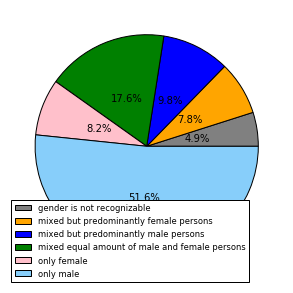

In [14]:
several_people=person_docs.groupby("person_plural").size()

colors = [ 'grey','orange','blue','green', 'pink', 'lightskyblue' ]
print several_people
plt.figure(1, figsize=(5,5))
plt.pie(several_people.values, colors=colors, autopct='%1.1f%%',pctdistance=0.46) #, pctdistance=1.1, labeldistance=1.2
plt.legend(several_people.index.str.replace("_"," "),loc="best",fontsize='small')
plt.show()

In [15]:
df.rename(columns={'image_link':'real_url'}, inplace=True)
result_and_pages = pd.merge(df, person_docs, how="right", on="real_url")#595 (580 unique images)
#load about_pages
about_pages=pd.read_csv('de/all_data_bias_labour_gender.csv',sep='\t', encoding='utf-8',index_col=0)#885
#merga all data and image results
df_images_and_all = pd.merge(about_pages,result_and_pages, how="right", on="profession")

C:\Anaconda\lib\site-packages\pandas\core\frame.py:2697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


# Group by labour market

Amount of data in each group: labor_market_domin
female    202
male      389
dtype: int64



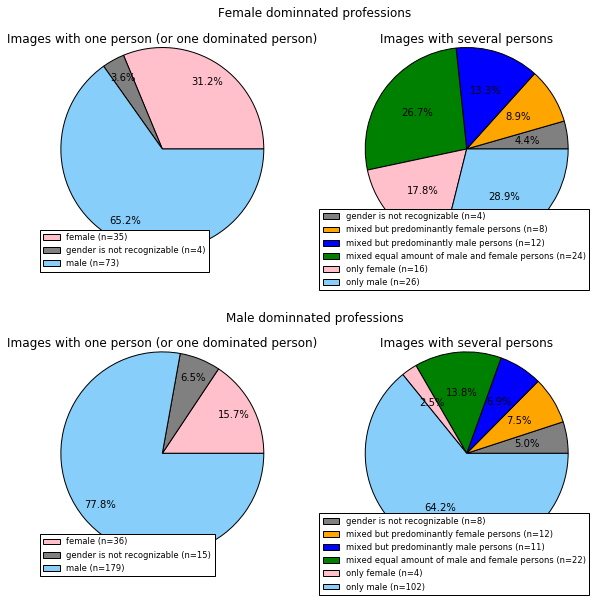

In [29]:
groups=df_images_and_all.groupby("labor_market_domin")
print "Amount of data in each group:",groups.size()
print 
#================hidden subplot
fig, big_axes = plt.subplots( figsize=(10, 10) , nrows=len(groups), ncols=1)
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(groups.size().index[row-1].title()+" dominnated professions", fontsize=12)
    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False
#=================    

data={}  
i=1    
for group_name, df_group in groups:

    #print "Labour market, where dominant are:",group_name
    #=====singular person
    singular = df_group.groupby("person_singular_dom").size()+df_group.groupby("person_singular_nondom").size()
    #print test
    ax1 = fig.add_subplot(len(groups),2,i) 
    colors = ['pink', 'grey','lightskyblue','green','orange','blue']
    ax1.pie(singular.values, colors=colors, autopct='%1.1f%%', pctdistance=0.8)#, labeldistance=1.2
    ax1.legend(singular.index.str.replace("_"," ").values+singular.apply(lambda x:" (n="+str(int(x))+")").values,loc="best",fontsize='small')
    ax1.set_title("Images with one person (or one dominated person)", position=(0.5, 0.9))
    
    #=====plural
    plural= df_group.groupby("person_plural").size()
    #print plural
    ax2 = fig.add_subplot(len(groups),2,i+1)
    colors = [ 'grey','orange','blue','green', 'pink', 'lightskyblue' ]
    ax2.pie(plural.values, colors=colors, autopct='%1.1f%%')#,pctdistance=0.46)
    ax2.legend(plural.index.str.replace("_"," ").values+plural.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',bbox_to_anchor=(1, 0.28))#,frameon=False)
    ax2.set_title("Images with several persons", position=(0.5, 0.9))
    i+=2
    #save data
    data[group_name]={"plural":plural.values,"singular":singular.values}
plt.show()

The null hypothesis states that knowing the level of Variable A does not help you predict the level of Variable B. That is, the variables are independent.

H0: category of image and gender that dominate in profession are independent.

Ha: category of image and gender that dominate in profession are not independent. 

For this analysis, the significance level is 0.05. Using sample data, we will conduct a chi-square/G- test for independence.

## Simulate the distribution of test statistic

Results from R (Simulating the Chi-squared P-value by using "Monte Carlo" test, Using 100,000 iterations ):

 Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x

X-squared = 51.55, df = NA, p-value = 1e-05

## G- test (log-likelihood ratio) for independence

In [30]:
#dependent variable: category of image
#independent variable: gender that dominate in profession 
from scipy.stats import chi2_contingency
#all cateories of images together
T_all=[np.concatenate([data["male"]["singular"],data["male"]["plural"]]),
       np.concatenate([data["female"]["singular"],data["female"]["plural"]])]
print T_all
print chi2_contingency(T_all,lambda_="log-likelihood")#([[36,15,179,8,12,11,22,4,102],[35,4,73,4,8,12,24,16,26]])

[array([ 36,  15, 179,   8,  12,  11,  22,   4, 102], dtype=int64), array([35,  4, 73,  4,  8, 12, 24, 16, 26], dtype=int64)]
(50.849942982519906, 2.8046342423291317e-08, 8L, array([[  46.73265651,   12.50592217,  165.8680203 ,    7.89847716,
          13.1641286 ,   15.13874788,   30.27749577,   13.1641286 ,
          84.25042301],
       [  24.26734349,    6.49407783,   86.1319797 ,    4.10152284,
           6.8358714 ,    7.86125212,   15.72250423,    6.8358714 ,
          43.74957699]]))


These results indicate that there is a statistically significant relationship between the category of images and gender that dominate in profession 

( Pearson’s chi-square with 8 degrees of freedom = 51.55, p = 2.055e-08).
                        
( G-value with 8 degrees of freedom = 50.84, p = 2.804e-08).

There is a difference in the images composition between the female and male dominated professions, but it would be interesting to see which image categories are a significantly higher proportion of the total in each habitat. To do that, we will do 2x2 contigency table for each image category vs. all others. 
We will use holm-bonferroni OR Hommel correction in order to controll the familywise error rate.
OR Benjamini-Hochberg the false discovery rate (FDR)

(Because there are 9 comparisons, applying the Bonferroni correction means that a p-value has to be less than 0.05/9=0.0056 to be significant at the p<0.05 level.)  


## Post-hoc tests

In [242]:
p_val=[]
g_val=[]
#print "g-val, p-val without correction, degrees of freedom, exp_val:"
for i in range(0,len(T_all[0])):
    g,p,df,exp_v=chi2_contingency([[T_all[0][i],T_all[1][i]],[sum(T_all[0])-T_all[0][i],sum(T_all[1])-[T_all[1][i]]]]
                                                       ,lambda_="log-likelihood")
    print g,p,df 
    g_val.append(g)
    p_val.append(p)
names_c=["female (singular)","gender is not recognizable (singular)","male (singular)",
       "gender is not recognizable (plural)","mixed but predominantly female persons",
       "mixed but predominantly male persons","mixed, equal amount of male and female","only female (plural)",
      "only male (plural)"]
#print chi2_contingency([[23,8],[389-23,202-8]],lambda_="log-likelihood")#male-female d.p.; gender is not recognizable (all) 
#then 0.05/8=0.00625

In [249]:
from statsmodels.sandbox.stats.multicomp import multipletests

print "Hommel correction:"
res= multipletests(p_val, alpha=0.05, method='hommel')[:2]
print res
#So "female (singular)","only female" and "only male" categories show signifficant difference between the female and male dominated professions.

print "Two stage FDR correction of Benjamini-Hochberg:"
res=multipletests(p_val, alpha=0.05, method='fdr_tsbh')[:2]
print "-"*75
print "========== image category =========== values(m/f)= reject = p_val_corrected"
print "-"*75
for i in range(0,len(T_all[0])):
    print "{:<38}  {:3} {:4}  {!r:>7}   {:<3.2e}".format(names_c[i],T_all[0][i],T_all[1][i],res[0][i],res[1][i])

Hommel correction:
(array([ True, False, False, False, False, False, False,  True,  True], dtype=bool), array([  4.93275082e-02,   8.07786105e-01,   1.30635000e-01,
         8.07786105e-01,   8.07786105e-01,   4.46739423e-01,
         7.83809998e-02,   4.84973789e-04,   1.42281674e-03]))
Two stage FDR correction of Benjamini-Hochberg:
---------------------------------------------------------------------------
========== image category =========== values(m/f)= reject = p_val_corrected
---------------------------------------------------------------------------
female (singular)                        36   35     True   1.01e-02
gender is not recognizable (singular)    15    4    False   1.79e-01
male (singular)                         179   73     True   2.09e-02
gender is not recognizable (plural)       8    4    False   3.59e-01
mixed but predominantly female persons   12    8    False   3.59e-01
mixed but predominantly male persons     11   12    False   7.45e-02
mixed, equal amount o

So "female (singular)","male (singular)","mixed, equal amount of male and female","only female" and "only male" categories show signifficant difference between the female and male dominated professions.

TODO: all posible pairswise comparosions of rows and all posible pairswise comparosions of columns
in order to see if the image categories are equally likely under each row.

"Ho: the image categories distributed equally", for each row [ gender that dominate in profession].


Literature:

MacDonald and Gardner (2000):PL MacDonald, RC Gardner. Type I Error Rate Comparisons of Post Hoc Procedures for I j Chi-Square Tables. - Educational and Psychological …, 2000

http://jpktd.blogspot.de/2013/04/multiple-testing-p-value-corrections-in.html

https://en.wikipedia.org/wiki/False_discovery_rate#Classification_of_m_hypothesis_tests

### var2 (perform testing for "singular persons" and "several persons" independently), Bonferroni correction is needed (alpha=0.05/2=0.025)

In [81]:
#dependent variable: category of image
#independent variable: gender that dominate in profession 
from scipy.stats import chi2_contingency#,wilcoxon,mannwhitneyu

print "Singular persons: "
T=np.array([data["male"]["singular"],data["female"]["singular"]])
print T
print chi2_contingency(T,lambda_="log-likelihood"),"\n"#contingency tables -> non-parametric;  
print "Several persons: "
T=np.array([data["male"]["plural"],data["female"]["plural"]])
print T
print chi2_contingency(T,lambda_="log-likelihood")#hypothesis test of independence of the observed frequencies in the contingency table
#we can reject null-hypothesis(p=0.00296):
#we can reject null-hypothesis(p=3.11e-07):

Singular persons: 
[[ 36  15 179]
 [ 35   4  73]]
(11.239616715881688, 0.0036253358092163458, 2L, array([[  47.74853801,   12.77777778,  169.47368421],
       [  23.25146199,    6.22222222,   82.52631579]])) 

Several persons: 
[[  8  12  11  22   4 102]
 [  4   8  12  24  16  26]]
(38.873253127861979, 2.5184992819764796e-07, 5L, array([[  7.6626506 ,  12.77108434,  14.68674699,  29.37349398,
         12.77108434,  81.73493976],
       [  4.3373494 ,   7.22891566,   8.31325301,  16.62650602,
          7.22891566,  46.26506024]]))


# Group by bias (from page existance on Wiki)

Amount of data in each group: Bias
female       3
male       548
neutral     44
dtype: int64
no_of_persons
several_persons_no_single_persons_depiction_is_dominant    3
dtype: int64
no_of_persons
one_person                                                 270
several_persons_but_one_persons_depiction_is_dominant       50
several_persons_no_single_persons_depiction_is_dominant    228
dtype: int64
no_of_persons
one_person                                                 22
several_persons_but_one_persons_depiction_is_dominant       3
several_persons_no_single_persons_depiction_is_dominant    19
dtype: int64


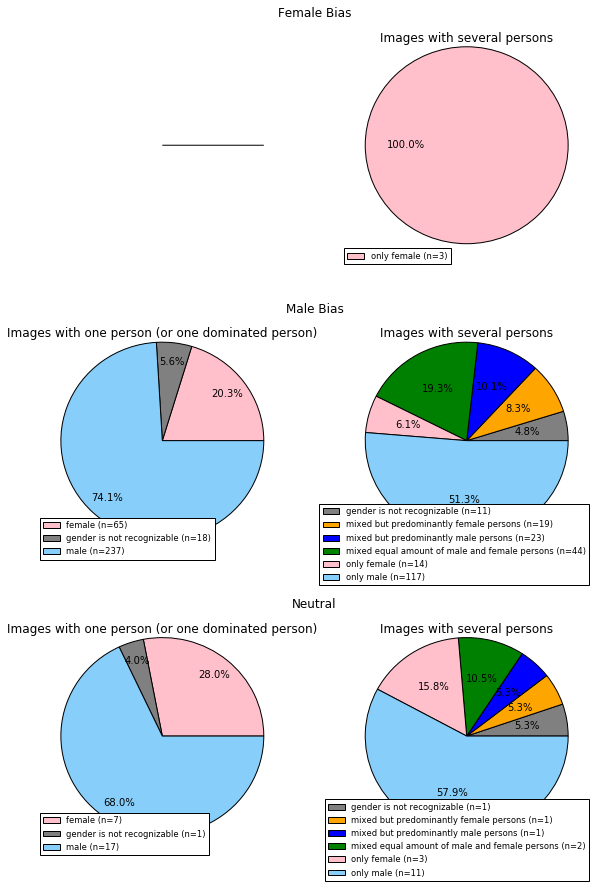

In [17]:
groups=df_images_and_all.groupby("Bias")
print "Amount of data in each group:",groups.size()

#================hidden subplot
fig, big_axes = plt.subplots( figsize=(10, 5*len(groups)) , nrows=len(groups), ncols=1)
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(groups.size().index[row-1].title() if groups.size().index[row-1]=="neutral" else groups.size().index[row-1].title()+" Bias", fontsize=12)
    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False
#=================    
  
data={}
i=1    
for group_name, df_group in groups:
    num_of_pers =  df_group.groupby("no_of_persons").size()
    print num_of_pers
    #print "Bias:",group_name
    #=====singular person
    if (df_group.person_singular_dom.count()>0) | (df_group.person_singular_nondom.count()>0):#
        #singular = df_group.groupby("person_singular_dom").size()+df_group.groupby("person_singular_nondom").size()
        singular=df_group.groupby("person_singular_dom").size().add(df_group.groupby("person_singular_nondom").size(),fill_value=0)
        #print test
        ax1 = fig.add_subplot(3,2,i) 
        colors = ['pink', 'grey','lightskyblue','green','orange','blue']
        ax1.pie(singular.values, colors=colors, autopct='%1.1f%%', pctdistance=0.8)#, labeldistance=1.2)
        ax1.legend(singular.index.str.replace("_"," ").values+singular.apply(lambda x:" (n="+str(int(x))+")").values,loc="best",fontsize='small')
        ax1.set_title("Images with one person (or one dominated person)", position=(0.5, 0.9))
        singular_values=singular.values
    else:
        ax1 = fig.add_subplot(3,2,i) 
        ax1.pie([0])
        ax1.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        ax1._frameon = False
        singular_values=np.array([0,0,0])
    #=====plural
    plural= df_group.groupby("person_plural").size()
    plural_values=plural.values
    #print plural
    ax2 = fig.add_subplot(3,2,i+1)
    if len(plural)==1:
        colors = ['pink']
        plural_values=np.array([plural.values[0],0,0,0,0,0])
    else:
        colors = [ 'grey','orange','blue','green', 'pink', 'lightskyblue' ]
    ax2.pie(plural.values, colors=colors, autopct='%1.1f%%')#,pctdistance=0.46)
    ax2.set_title("Images with several persons", position=(0.5, 0.9))
    if len(plural)>4:
        ax2.legend(plural.index.str.replace("_"," ").values+plural.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',bbox_to_anchor=(1, 0.26))#,frameon=False)
    else:
        ax2.legend(plural.index.str.replace("_"," ").values+plural.apply(lambda x:" (n="+str(int(x))+")").values,loc=3,fontsize='small')
    
    i+=2
    data[group_name]={"plural":plural_values,"singular":singular_values}
plt.show()

We can see that in female bias group all the images  are "only female". 

We will exclude female bias group from the following G-test for independence-

The null hypothesis states that knowing the level of Variable A does not help you predict the level of Variable B. That is, the variables are independent.

H0: category of image and assigned bias category (male and neutral) are independent.

Ha: category of image and assigned bias category (male and neutral) are not independent. 

In [252]:
#both cateories of images together
print chi2_contingency([[65,18,237,11,19,23,44,14,117],[7,1,17,1,1,1,2,3,11]])

(4.9039513317710934, 0.7677909177416653, 8L, array([[  66.64864865,   17.58783784,  235.12162162,   11.10810811,
          18.51351351,   22.21621622,   42.58108108,   15.73648649,
         118.48648649],
       [   5.35135135,    1.41216216,   18.87837838,    0.89189189,
           1.48648649,    1.78378378,    3.41891892,    1.26351351,
           9.51351351]]))


Since the p-value (0.76) is more than the significance level (0.05), we can accept the null hypothesis. Thus, we conclude that there is no relationship between the category of image and assigned bias category (male or neutral).

TODO: while we have cells with values<5, use Fisher's exact test OR perform Monte Carlo simulations

## Simulate the distribution of test statistic

Results from R (Simulating the Chi-squared P-value by using "Monte Carlo" test, Using 100,000 iterations ):  

For male bias and neutral bias comparison:

> x <- cbind(A=c(65,18,237,11,19,23,44,14,117),B=c(7,1,17,1,1,1,2,3,11))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x

X-squared = 4.904, df = NA, p-value = 0.7738


For male bias and female bias comparison:

> x <- cbind(A=c(65,18,237,11,19,23,44,14,117),B=c(0,0,0,0,0,0,0,3,0))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x

X-squared = 94.751, df = NA, p-value = 6e-05

In [8]:
#TODO: add post hoc test for male-female comparison
from scipy import stats
oddsratio, pvalue = stats.fisher_exact([[65, 18], [7, 1]])
print oddsratio,pvalue
oddsratio, pvalue = stats.fisher_exact([[237, 11], [17, 1]])
print oddsratio,pvalue


0.515873015873 1.0
1.26737967914 0.576573818435


### var2 (perform testing for "singular persons" and "several persons" independently), Bonferroni correction is needed (alpha=0.05/2=0.025)v

In [253]:

print data["female"]["singular"]
print "Singular male and neutral:"
T=np.array([data["male"]["singular"],data["neutral"]["singular"]])
print T
print chi2_contingency(T)
print "Plural male and neutral:"
print data["female"]["plural"],
T=np.array([data["male"]["plural"],data["neutral"]["plural"]])
print T
print chi2_contingency(T)

[0 0 0]
Singular male and neutral:
[[  65.   18.  237.]
 [   7.    1.   17.]]
(0.88358517017198479, 0.64288296514270238, 2L, array([[  66.7826087 ,   17.62318841,  235.5942029 ],
       [   5.2173913 ,    1.37681159,   18.4057971 ]]))
Plural male and neutral:
[3 0 0 0 0 0] [[ 11  19  23  44  14 117]
 [  1   1   1   2   3  11]]
(3.8749210757672632, 0.56756129494269936, 5L, array([[  11.07692308,   18.46153846,   22.15384615,   42.46153846,
          15.69230769,  118.15384615],
       [   0.92307692,    1.53846154,    1.84615385,    3.53846154,
           1.30769231,    9.84615385]]))


# Group by gender of profession label

Amount of data in each group: prof_gender
female      12
male       558
neutral     25
dtype: int64
no_of_persons
one_person                                                 5
several_persons_no_single_persons_depiction_is_dominant    7
dtype: int64
no_of_persons
one_person                                                 278
several_persons_but_one_persons_depiction_is_dominant       51
several_persons_no_single_persons_depiction_is_dominant    229
dtype: int64
no_of_persons
one_person                                                  9
several_persons_but_one_persons_depiction_is_dominant       2
several_persons_no_single_persons_depiction_is_dominant    14
dtype: int64


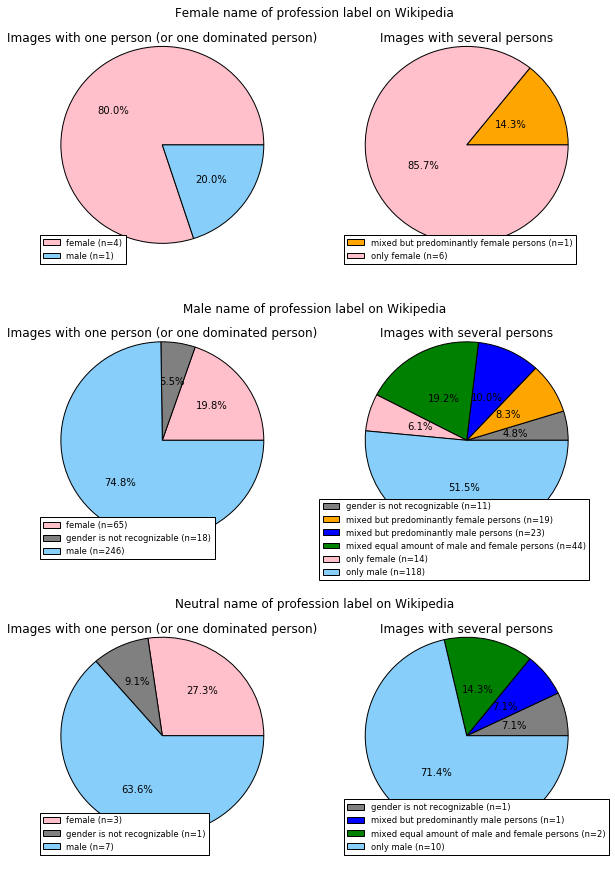

In [32]:
groups=df_images_and_all.groupby("prof_gender")
print "Amount of data in each group:",groups.size()

#================hidden subplot
fig, big_axes = plt.subplots( figsize=(10, 5*len(groups)) , nrows=len(groups), ncols=1)
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title(""+groups.size().index[row-1].title()+" name of profession label on Wikipedia", fontsize=12)
    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False
#=================    
    
i=1    
for group_name, df_group in groups:
    num_of_pers =  df_group.groupby("no_of_persons").size()
    print num_of_pers

    #=====singular person
    if (df_group.person_singular_dom.count()>0) | (df_group.person_singular_nondom.count()>0):#
        if (df_group.person_singular_dom.count()>0) & (df_group.person_singular_nondom.count()>0):
            singular=df_group.groupby("person_singular_dom").size().add(df_group.groupby("person_singular_nondom").size(),fill_value=0)
        elif (df_group.person_singular_dom.count()>0):
            singular=df_group.groupby("person_singular_dom").size()
        else:
            singular=df_group.groupby("person_singular_nondom").size()
        #print singular
        ax1 = fig.add_subplot(3,2,i) 
        if len(singular)==2:
            colors = ['pink', 'lightskyblue']
            singular_values=np.array([singular.values[0],0,singular.values[1]])
        else:
            colors = ['pink', 'grey','lightskyblue','green','ccccc','blue']
            singular_values=np.array(singular.values, dtype=int64)
        ax1.pie(singular.values, colors=colors, autopct='%1.1f%%') #, pctdistance=1.1, labeldistance=1.2
        ax1.legend(singular.index.str.replace("_"," ").values+singular.apply(lambda x:" (n="+str(int(x))+")").values,loc=3,fontsize='small')
        ax1.set_title("Images with one person (or one dominated person)", position=(0.5, 0.9))
    else:
        ax1 = fig.add_subplot(3,2,i) 
        ax1.pie([0])
        ax1.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        ax1._frameon = False
    #=====plural
    plural= df_group.groupby("person_plural").size()
    #print plural
    ax2 = fig.add_subplot(3,2,i+1)
    if len(plural)==1:
        colors = ['pink']
    elif len(plural)==2:
        colors = ['orange', 'pink']
        plural_values=np.array([0,plural.values[0],0,0,plural.values[1],0])
    elif len(plural)==4:
        colors = ['grey','blue','green', 'lightskyblue']
        plural_values=np.array([plural.values[0],0,plural.values[1],plural.values[2],0,plural.values[3]],dtype=int64)
    else:
        colors = [ 'grey','orange','blue','green', 'pink', 'lightskyblue' ]
        plural_values=plural.values
    ax2.pie(plural.values, colors=colors, autopct='%1.1f%%',pctdistance=0.48)
    ax2.set_title("Images with several persons", position=(0.5, 0.9))
    if len(plural)<5:
        ax2.legend(plural.index.str.replace("_"," ").values+plural.apply(lambda x:" (n="+str(int(x))+")").values,loc=3,fontsize='small')
    else:
        ax2.legend(plural.index.str.replace("_"," ").values+plural.apply(lambda x:" (n="+str(int(x))+")").values,fontsize='small',bbox_to_anchor=(1, 0.28))#,frameon=False)
    data[group_name]={"plural":plural_values,"singular":singular_values}    
    i+=2
plt.show()

In [34]:
T_all=[ np.concatenate([data["female"]["singular"],data["female"]["plural"]]),
        np.concatenate([data["male"]["singular"],data["male"]["plural"]]),
       np.concatenate([data["neutral"]["singular"],data["neutral"]["plural"]])]
print T_all

[array([4, 0, 1, 0, 1, 0, 0, 6, 0], dtype=int64), array([ 65,  18, 246,  11,  19,  23,  44,  14, 118], dtype=int64), array([ 3,  1,  7,  1,  0,  1,  2,  0, 10], dtype=int64)]


## Simulate the distribution of test statistic

Results from R (Simulating the Chi-squared P-value by using "Monte Carlo" test, Using 100,000 iterations ):  

> x <- cbind(A=c(64,0,1,0,1,0,0,6,0),B=c(65,18,246,11,19,23,44,14,118),C=c(3,1,7,1,0,1,2,0,10))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x

X-squared = 263.15, df = NA, p-value = 1e-05


## Post hoc tests

In [44]:
from scipy.stats import chi2_contingency
p_val=[]
g_val=[]
print "g-val, p-val without correction, degrees of freedom, exp_val:"
for i in range(0,len(T_all[0])):
    g,p,df,exp_v=chi2_contingency([[T_all[0][i],T_all[1][i],T_all[2][i]],
                                   [sum(T_all[0])-T_all[0][i],sum(T_all[1])-T_all[1][i],sum(T_all[2])-T_all[2][i]]]
                                                        ,lambda_="log-likelihood")
    print g,p,df
    g_val.append(g)
    p_val.append(p)
names_c=["female (singular)","gender is not recognizable (singular)","male (singular)",
       "gender is not recognizable (plural)","mixed but predominantly female persons",
       "mixed but predominantly male persons","mixed, equal amount of male and female","only female (plural)",
      "only male (plural)"]

from statsmodels.sandbox.stats.multicomp import multipletests

#print "Hommel correction:"
#res= multipletests(p_val, alpha=0.05, method='hommel')[:2]
#print res
#So "only female" and "only male" categories show signifficant difference between the male,female and neutral professions.

print "\nTwo stage FDR correction of Benjamini-Hochberg:"
res=multipletests(p_val, alpha=0.05, method='fdr_tsbh')[:2]
print "-"*75
print "========== image category =========== values(f/m/n)= reject = p_val_corrected"
print "-"*75
for i in range(0,len(T_all[0])):
    print "{:<38}  {:2} {:3} {:3}  {!r:>7}   {:<3.2e}".format(names_c[i],T_all[0][i],T_all[1][i],T_all[2][i],res[0][i],res[1][i])

g-val, p-val without correction, degrees of freedom, exp_val:
3.79113912135 0.150232744011 2
0.829610872304 0.66046877155 2
9.8191888351 0.00737547908971 2
0.882930166673 0.643093544919 2
2.36663577752 0.306260911381 2
0.999355022651 0.606726290524 2
1.95210941158 0.376794736325 2
27.5634861977 1.03434405148e-06 2
10.2049440618 0.00608169383254 2

Two stage FDR correction of Benjamini-Hochberg:
---------------------------------------------------------------------------
========== image category =========== values(f/m/n)= reject = p_val_corrected
---------------------------------------------------------------------------
female (singular)                        4  65   3    False   2.25e-01
gender is not recognizable (singular)    0  18   1    False   4.40e-01
male (singular)                          1 246   7     True   1.48e-02
gender is not recognizable (plural)      0  11   1    False   4.40e-01
mixed but predominantly female persons   1  19   0    False   3.68e-01
mixed but predomi

So "male (singular)","only female (plural)" and "only male (plural)" categories show signifficant difference between the male,female and neutral professions.

x <-cbind(A=c(4, 65, 3), B=c(8, 493, 22))
x <-cbind(A=c(0, 18, 1), B=c(12, 540, 24))
x <-cbind(A=c(1, 246,7), B=c(11, 312, 18))
x <-cbind(A=c(0, 11, 1), B=c(12, 547, 24))
x <-cbind(A=c(1, 19, 0), B=c(11, 539, 25))
x <-cbind(A=c(0, 23, 1), B=c(12, 535, 24))
x <-cbind(A=c(0, 44, 2), B=c(12, 514, 23))
x <-cbind(A=c(6, 14, 0), B=c(6, 544, 25))
x <-cbind(A=c(0, 118, 10), B=c(12, 440, 15))

> x <-cbind(A=c(4, 65, 3), B=c(8, 493, 22))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 5.1935, df = NA, p-value = 0.08504

> x <-cbind(A=c(0, 18, 1), B=c(12, 540, 24))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 0.45037, df = NA, p-value = 1

> x <-cbind(A=c(1, 246,7), B=c(11, 312, 18))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 8.4392, df = NA, p-value = 0.0135

> x <-cbind(A=c(0, 11, 1), B=c(12, 547, 24))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 0.75041, df = NA, p-value = 1

> x <-cbind(A=c(1, 19, 0), B=c(11, 539, 25))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 1.7861, df = NA, p-value = 0.3719

> x <-cbind(A=c(0, 23, 1), B=c(12, 535, 24))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 0.51568, df = NA, p-value = 1

> x <-cbind(A=c(0, 44, 2), B=c(12, 514, 23))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 1.0266, df = NA, p-value = 0.7094

> x <-cbind(A=c(6, 14, 0), B=c(6, 544, 25))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 82.472, df = NA, p-value = 1e-05

> x <-cbind(A=c(0, 118, 10), B=c(12, 440, 15))
> chisq.test(x, simulate.p.value=TRUE, B=1e5)

        Pearson's Chi-squared test with simulated p-value (based on 1e+05
        replicates)

data:  x
X-squared = 8.3938, df = NA, p-value = 0.01496

In [58]:
p_all=[0.08504,1,0.0135,1,0.3719,1,0.7094,1e-05,0.01496]
print "Two stage FDR correction of Benjamini-Hochberg:"
res=multipletests(p_all, alpha=0.05, method='fdr_tsbh')[:2]
print "-"*75
print "========== image category =========== values(f/m/n)= reject = p_val_corrected"
print "-"*75
for i in range(0,len(T_all[0])):
    print "{:<38}  {:2} {:3} {:3}  {!r:>7}   {:<3.2e}".format(names_c[i],T_all[0][i],T_all[1][i],T_all[2][i],res[0][i],res[1][i])


Two stage FDR correction of Benjamini-Hochberg:
---------------------------------------------------------------------------
========== image category =========== values(f/m/n)= reject = p_val_corrected
---------------------------------------------------------------------------
female (singular)                        4  65   3    False   1.28e-01
gender is not recognizable (singular)    0  18   1    False   6.67e-01
male (singular)                          1 246   7     True   2.99e-02
gender is not recognizable (plural)      0  11   1    False   6.67e-01
mixed but predominantly female persons   1  19   0    False   4.46e-01
mixed but predominantly male persons     0  23   1    False   6.67e-01
mixed, equal amount of male and female   0  44   2    False   6.67e-01
only female (plural)                     6  14   0     True   6.00e-05
only male (plural)                       0 118  10     True   2.99e-02


# More:

http://www.ats.ucla.edu/stat/stata/whatstat/whatstat.htm

http://www.ats.ucla.edu/stat/mult_pkg/whatstat/choosestat.html

There are 53.6% man and 46.4% woman according to German labour Market statistics.


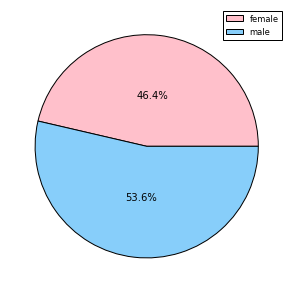

Statistics about professions that are described on Wikipedia: 62.1% man and 37.9% woman in German Labour market.


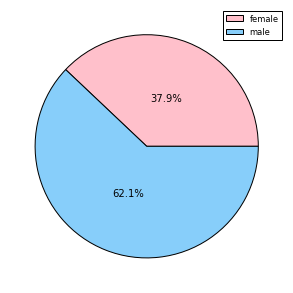

Images results: We combined singular persons and several persons according to magority (male or female):
female     95
male      346
dtype: float64


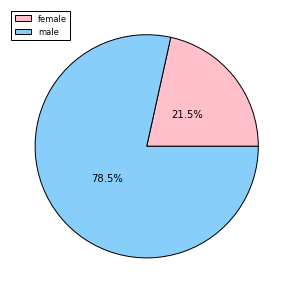

In [44]:
import pandas as pd
#From German labour Market Statistics (2015):
m_n=16504172#Männer 
f_n=14267125#Frauen 
m_proc=100*float(m_n)/(m_n+f_n)
f_proc=100-m_proc
print "There are {0:.1f}% man and {1:.1f}% woman according to German labour Market statistics.".format(m_proc,f_proc)
plt.figure(1, figsize=(5,5))
colors = ['pink', 'lightskyblue']
plt.pie([f_n,m_n], colors=colors,autopct='%1.1f%%',pctdistance=0.46) #, pctdistance=1.1, labeldistance=1.2
plt.legend(new_all.index,loc="best",fontsize='small')
plt.show()
#===data where if there are male and female profession then statistics count it 2 times:
#all_df=pd.read_csv("de/labour_market_for_all_pages.csv",sep='\t', encoding='utf-8',index_col=0)
#f_wiki_proc=all_df.Frauen.mean()
#m_wiki_proc=100-f_wiki_proc
#print "There are {0:.1f}% man and {1:.1f}% woman according to German labour Market statistics.".format(m_wiki_proc,f_wiki_proc)
#===
df_all_subgroups=pd.read_csv("de/labourmarket_subgroups.csv",sep='\t', encoding='utf-8',index_col=0)
f_wiki_proc=df_all_subgroups.Frauen_ratio.mean()
m_wiki_proc=100-f_wiki_proc
print "Statistics about professions that are described on Wikipedia: {0:.1f}% man and {1:.1f}% woman in German Labour market.".format(m_wiki_proc,f_wiki_proc)
plt.figure(1, figsize=(5,5))
colors = ['pink', 'lightskyblue']
plt.pie([f_wiki_proc,m_wiki_proc], colors=colors,autopct='%1.1f%%',pctdistance=0.46) #, pctdistance=1.1, labeldistance=1.2
plt.legend(new_all.index,loc="best",fontsize='small')
plt.show()

person_all=person_docs[~(person_docs.no_of_persons.str.contains("no_person|image_is_not_shown"))]
person_all.loc[:,'person_plural']=result_old['person_plural'].str.replace("only_","")\
    .str.replace("mixed_but_predominantly_","").str.replace("_persons","")
all_singular_persons = person_all.groupby("person_singular_dom").size()+person_all.groupby("person_singular_nondom").size()
several_people=person_all.groupby("person_plural").size()
new_all=several_people.add(all_singular_persons ,fill_value=0).drop(["gender_is_not_recognizable",
                                                                     "mixed_equal_amount_of_male_and_female"])

print "Images results: We combined singular persons and several persons according to magority (male or female):\n",new_all
plt.figure(1, figsize=(5,5))
colors = ['pink', 'lightskyblue']
plt.pie(new_all.values, colors=colors,autopct='%1.1f%%',pctdistance=0.46) #, pctdistance=1.1, labeldistance=1.2
plt.legend(new_all.index,loc="best",fontsize='small')
plt.show()
#print person_all[pd.notnull(person_all['person_plural'])].person_plural.value_counts(normalize=True,dropna=False)
f_perc_all=100. * new_all.female / (new_all.female+new_all.male)
m_perc_all=100. * new_all.male / (new_all.female+new_all.male)

In [40]:
from scipy.stats import chisquare
print chisquare([95,346])#goodnes of fit where the expected frequencies are uniform 
print chisquare([20593.8969521045, 23784.433962264149])#goodnes of fit where we expect 0.5 chance for both

Power_divergenceResult(statistic=142.85941043083901, pvalue=6.3091412612294671e-33)
Power_divergenceResult(statistic=229.38056036493666, pvalue=8.1364098032284914e-52)


In [16]:
from scipy.stats import chisquare,ks_2samp,chi2_contingency

#check whether amount of male and female in German labour market and amount of male afemale persons on images 
#are from the same distribution
cat1=[df_all_subgroups.Frauen.mean(),df_all_subgroups[u'Männer'].mean()]
print cat1
cat2=new_all.values
print cat2
print chi2_contingency(np.array([cat1, cat2]))
#print ks_2samp(cat1, cat2)#samples are drawn from the same distribution?
print chisquare(np.array([cat1,cat2]))#goodnes of fit

[20593.8969521045, 23784.433962264149]
[  95.  346.]
(107.6173410810016, 3.2602012391591332e-25, 1L, array([[ 20485.32846124,  23893.00245313],
       [   203.56849087,    237.43150913]]))
Power_divergenceResult(statistic=array([ 20310.64184938,  22766.27877735]), pvalue=array([ 0.,  0.]))


In [ ]:
#If data are not normally distributed -> use  Box-Cox power transformation of data

In [ ]:
from scipy.stats.distributions import chi2
#===== manual calculation of p-val
def ttes(T):
    PR = T.sum(1) / float(T.sum())
    PC = T.sum(0) / float(T.sum())
    E = np.outer(PR, PC)
    C = T.sum()*E
    cs = ((T-C)**2/C).sum()
    df = (T.shape[0]-1)*(T.shape[1]-1)
    pvalue = 1 - chi2.cdf(cs, df)
    #print cs,pvalue,df
    return cs,pvalue,df,E
#===================


#from http://stats.stackexchange.com/questions/135796/is-the-chi-squared-test-appropriate-with-many-small-counts-in-a-5x2-table
#Fisher's exact test
#scipy.stats.fisher_exact(table, alternative='two-sided')
#Performs a Fisher exact test on a 2x2 contingency table.
#http://vassarstats.net/fisher2x3.html
#http://stats.stackexchange.com/questions/14226/given-the-power-of-computers-these-days-is-there-ever-a-reason-to-do-a-chi-squa/14230#14230
#https://www.mrnoutahi.com/2016/01/03/Fisher-exac-test-for-mxn-table/

#Other solutions:
#1)Simulating the Chi-squared P-value
#One way to check is to simulate the true distribution of the χ2 statistic. R offers a "Monte Carlo" test.
#chisq.test(x, simulate.p.value=TRUE, B=1e5)
#2)Another approach is to bootstrap the test


In [76]:
#Example of cross-tab
pd.crosstab(df_images_and_all.labor_market_domin,
            df_images_and_all.person_singular_dom, margins = True)

person_singular_dom,female,gender_is_not_recognizable,male,All
labor_market_domin,,,,
female,11,1,12,202
male,1,1,26,389
All,12,2,39,595
